# Encapsulation

* 모듈이나 클래스로 만드는 작업
* .ipynb에서 개발한 후 서비스화 할 때는 .py로 만드는데
* 이때 모듈 혹은 클래스로 만들어 서버단에 배포한다. 

서비스 내용 
- S3버킷의 이미지에서 객체를 탐지하는 애플리케이션을 개발

개발순서
1. S3과 연동하는 기능 캡슐화
2. Recognition 기능 캡슐화
3. object_detection_demo 애플리케이션 main

시퀀스 다이어그램

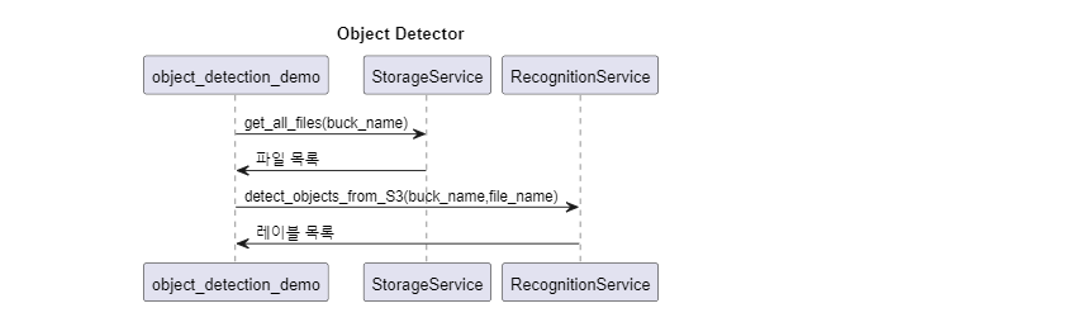

## 1.S3과 연동하는 기능 캡슐화

### StorageService 클래스 만들기

* get_all_files(self,buck_name)-> 파일리스트 반환
* 파일리스트 (key:value) 딕셔너리 형식으로 반환
* 다음과 같은 내용을 포함할 것
    - "location":버킷이름 
    - "file_name":파일이름
    - "url":

In [16]:
import boto3

class StorageService:
    def __init__(self):
        self.s3 = boto3.client('s3')
        
    def get_all_files(self, buck_name):
            buck = boto3.client('s3',region_name='ap-northeast-2')
            response = buck.list_objects_v2(Bucket='sesac.yb')
            files = []
            for i in response['Contents']:
                file_info = {
                    "location": buck_name,
                    "file_name": 'StorageService.py',
                    "url": self.s3.generate_presigned_url(
                        ClientMethod='get_object',
                        Params={
                            'Bucket': buck_name,
                            'Key': i['Key']
                        }
                    )
                }
                files.append(file_info)
            return files

In [48]:
import boto3
import random

class StorageService() :
    
    def __init__(self) :
        ''' '''
    
    def get_all_files(self, buck_name) :
        buck = boto3.client('s3', region_name='ap-northeast-2')
        response = buck.list_objects_v2(Bucket=buck_name)

        ## file_list 만들기
        file_list = response['Contents']
        
        ## file_list에서 file_name뽑아서 list에 담기
        file_names = [i['Key'] for i in file_list]
                
        ## region 뽑기
        region = response['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
        
        ## url 형식 만들기
        url = f'http://s3.{region}.amazonaws.com/{buck_name}/'
        
        
        flist = [{'location' : buck_name, 'file_name' : fname, 'url' : url + fname} for fname in file_names]
        
        return flist

### 클래스 호출 테스트 하기

In [49]:
bname = 'sesac.yb'
storage = StorageService()
flist = storage.get_all_files(bname)
flist

[{'location': 'sesac.yb',
  'file_name': 'jellyfish.jpg',
  'url': 'http://s3.ap-northeast-2.amazonaws.com/sesac.yb/jellyfish.jpg'},
 {'location': 'sesac.yb',
  'file_name': 'shark.jpg',
  'url': 'http://s3.ap-northeast-2.amazonaws.com/sesac.yb/shark.jpg'},
 {'location': 'sesac.yb',
  'file_name': '강영현.jpg',
  'url': 'http://s3.ap-northeast-2.amazonaws.com/sesac.yb/강영현.jpg'}]

## 2.Recognition 클래스 만들기

In [94]:
import boto3

class RecognitionService:
    def __init__(self, region_name='ap-northeast-2'):
        self.rekognition = boto3.client('rekognition', region_name=region_name)

    def detect_objects_from_S3(self, bucket_name, file_name):
        response = self.rekognition.detect_labels(
            Image={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': file_name
                }
            }
        )
        return response
    

In [100]:
import boto3

class RecognitionService() :
    
    def __init__(self) :
        ''' '''
        
    def detect_objects_from_S3(self, bname, filename) :
        
        client = boto3.client('rekognition',region_name='ap-northeast-2')

        res = client.detect_labels(Image={
                                    'S3Object':{
                                        'Bucket' : bname,
                                        'Name' : filename}})['Labels']    
        
        response = [{'label' : i['Name'], 'confidence' : i['Confidence']} for i in res]
        
        return response

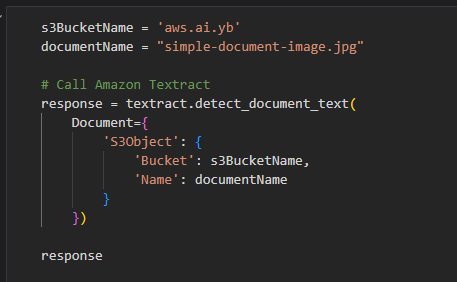

3번 파일 document 불러오는 부분 참조

### 클래스 호출 테스트

In [102]:
bname = 'sesac.yb'
recog = RecognitionService()
response = recog.detect_objects_from_S3(bname,'jellyfish.jpg')
response

[{'label': 'Animal', 'confidence': 95.51139831542969},
 {'label': 'Sea Life', 'confidence': 95.51139831542969},
 {'label': 'Invertebrate', 'confidence': 89.27242279052734},
 {'label': 'Jellyfish', 'confidence': 89.27242279052734},
 {'label': 'Aquatic', 'confidence': 87.78662872314453},
 {'label': 'Water', 'confidence': 87.78662872314453},
 {'label': 'Insect', 'confidence': 72.4620132446289},
 {'label': 'Outdoors', 'confidence': 71.27171325683594},
 {'label': 'Nature', 'confidence': 62.16446304321289},
 {'label': 'Reef', 'confidence': 55.77022933959961},
 {'label': 'Sea', 'confidence': 55.77022933959961}]

## 3. ObjectDetectionDemo

In [107]:
import random
from Recognition import RecognitionService
from StorageService import StorageService

class ObjectDetectionDemo() :
    
    def __init__(self) :
        ''' '''
        
    def demo(self, bname) :
        
        storage = StorageService()
        recog = RecognitionService()
        
        flist = storage.get_all_files(bname)
        file = random.choice(flist)
        filename = file['file_name']
        
        response = recog.detect_objects_from_S3(bname, filename)
        
        return filename, response

In [108]:
from ObjectDetectionDemo import ObjectDetectionDemo

ob=ObjectDetectionDemo()
filename, response = ob.demo('sesac.yb')
print(f'===== 객체 탐지 결과 [{filename}] =====')
response


===== 객체 탐지 결과 [jellyfish.jpg] =====


[{'label': 'Animal', 'confidence': 95.51139831542969},
 {'label': 'Sea Life', 'confidence': 95.51139831542969},
 {'label': 'Invertebrate', 'confidence': 89.27242279052734},
 {'label': 'Jellyfish', 'confidence': 89.27242279052734},
 {'label': 'Aquatic', 'confidence': 87.78662872314453},
 {'label': 'Water', 'confidence': 87.78662872314453},
 {'label': 'Insect', 'confidence': 72.4620132446289},
 {'label': 'Outdoors', 'confidence': 71.27171325683594},
 {'label': 'Nature', 'confidence': 62.16446304321289},
 {'label': 'Reef', 'confidence': 55.77022933959961},
 {'label': 'Sea', 'confidence': 55.77022933959961}]